# Recommender System: Collaborative Filtering on MovieLens Dataset

---

**Nama:** Muhammad Rizky Hajar  
**NIM:** 24.55.2714  
**Prodi:** PJJ Informatika  
**Konsentrasi:** Big Data dan Predictive Analytics (BDPA)  
**Mata Kuliah:** IT Platform and Infrastructure

---

## Tugas 3: Recommender System dengan Collaborative Filtering

**Konteks Tugas:**
- Menggunakan PySpark
- Dataset: MovieLens 100K
- Implementasi User-based dan Item-based Collaborative Filtering
- Similarity Metrics: Cosine Similarity & Pearson Correlation
- Perbandingan dengan ALS (Alternating Least Squares) Matrix Factorization

---

### Notebook Contents:
1. Setup & Introduction
2. Load & Explore Data
3. Data Preprocessing
4. User-based Collaborative Filtering
5. Item-based Collaborative Filtering
6. ALS Matrix Factorization
7. Evaluation & Comparison
8. Conclusion

## 1. Setup & Introduction

### 1.1 Apa itu Collaborative Filtering?

**Collaborative Filtering (CF)** adalah teknik recommender system yang memberikan rekomendasi berdasarkan perilaku pengguna lain yang memiliki preferensi serupa.

Ada dua pendekatan utama:

1. **User-based CF**: Mencari pengguna dengan preferensi serupa, lalu merekomendasikan item yang disukai oleh pengguna serupa tersebut.

2. **Item-based CF**: Mencari item yang mirip berdasarkan pola rating, lalu merekomendasikan item yang mirip dengan item yang sudah disukai pengguna.

### 1.2 Similarity Metrics

- **Cosine Similarity**: Mengukur sudut antara dua vektor rating. Nilai berkisar dari -1 hingga 1.
  
  $$\text{cosine}(u, v) = \frac{\sum_{i} r_{ui} \cdot r_{vi}}{\sqrt{\sum_{i} r_{ui}^2} \cdot \sqrt{\sum_{i} r_{vi}^2}}$$

- **Pearson Correlation**: Mengukur korelasi linear antara rating dua user/item dengan mempertimbangkan rata-rata rating.
  
  $$\text{pearson}(u, v) = \frac{\sum_{i} (r_{ui} - \bar{r}_u)(r_{vi} - \bar{r}_v)}{\sqrt{\sum_{i} (r_{ui} - \bar{r}_u)^2} \cdot \sqrt{\sum_{i} (r_{vi} - \bar{r}_v)^2}}$$

In [1]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, sqrt, sum as spark_sum, lit, desc, row_number
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, LongType, StringType

# MLlib imports untuk ALS
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("MovieLensRecommenderSystem") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

# Set log level to reduce noise
spark.sparkContext.setLogLevel("WARN")

print(f"Spark Version: {spark.version}")
print(f"Spark Session: {spark}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/22 18:36:29 WARN Utils: Your hostname, Rizkys-MacBook-Air-M4.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.154 instead (on interface en0)
26/01/22 18:36:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/22 18:36:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 4.1.1
Spark Session: <pyspark.sql.session.SparkSession object at 0x10eece150>


## 2. Load & Explore Data

### 2.1 MovieLens 100K Dataset

Dataset ini berisi:
- **100,000 ratings** dari 943 users untuk 1,682 movies
- Rating scale: 1-5
- Setiap user minimal memiliki 20 ratings

In [3]:
# Define schema untuk ratings (u.data)
# Format: user_id | item_id | rating | timestamp
ratings_schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", LongType(), True)
])

# Load ratings data
ratings_df = spark.read.csv(
    "../data/ml-100k/u.data",
    schema=ratings_schema,
    sep="\t"
)

print(f"Ratings loaded: {ratings_df.count()} records")
ratings_df.show(10)

Ratings loaded: 100000 records
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|   196|    242|   3.0|881250949|
|   186|    302|   3.0|891717742|
|    22|    377|   1.0|878887116|
|   244|     51|   2.0|880606923|
|   166|    346|   1.0|886397596|
|   298|    474|   4.0|884182806|
|   115|    265|   2.0|881171488|
|   253|    465|   5.0|891628467|
|   305|    451|   3.0|886324817|
|     6|     86|   3.0|883603013|
+------+-------+------+---------+
only showing top 10 rows


In [4]:
# Load movies data (u.item)
# Format: movie_id | title | release_date | video_release | imdb_url | genres...
movies_df = spark.read.csv(
    "../data/ml-100k/u.item",
    sep="|",
    header=False,
    encoding="ISO-8859-1"  # Dataset menggunakan encoding Latin-1
)

# Ambil hanya kolom yang diperlukan (movieId dan title)
movies_df = movies_df.select(
    col("_c0").cast(IntegerType()).alias("movieId"),
    col("_c1").alias("title")
)

print(f"Movies loaded: {movies_df.count()} movies")
movies_df.show(10, truncate=False)

Movies loaded: 1682 movies
+-------+----------------------------------------------------+
|movieId|title                                               |
+-------+----------------------------------------------------+
|1      |Toy Story (1995)                                    |
|2      |GoldenEye (1995)                                    |
|3      |Four Rooms (1995)                                   |
|4      |Get Shorty (1995)                                   |
|5      |Copycat (1995)                                      |
|6      |Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|
|7      |Twelve Monkeys (1995)                               |
|8      |Babe (1995)                                         |
|9      |Dead Man Walking (1995)                             |
|10     |Richard III (1995)                                  |
+-------+----------------------------------------------------+
only showing top 10 rows


In [5]:
# Basic statistics
print("=" * 50)
print("DATASET STATISTICS")
print("=" * 50)

n_users = ratings_df.select("userId").distinct().count()
n_movies = ratings_df.select("movieId").distinct().count()
n_ratings = ratings_df.count()

# Sparsity calculation
# Sparsity = 1 - (actual ratings / possible ratings)
sparsity = 1 - (n_ratings / (n_users * n_movies))

print(f"Number of Users: {n_users}")
print(f"Number of Movies: {n_movies}")
print(f"Number of Ratings: {n_ratings}")
print(f"Possible Ratings: {n_users * n_movies:,}")
print(f"Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
print("=" * 50)

DATASET STATISTICS
Number of Users: 943
Number of Movies: 1682
Number of Ratings: 100000
Possible Ratings: 1,586,126
Sparsity: 0.9370 (93.70%)


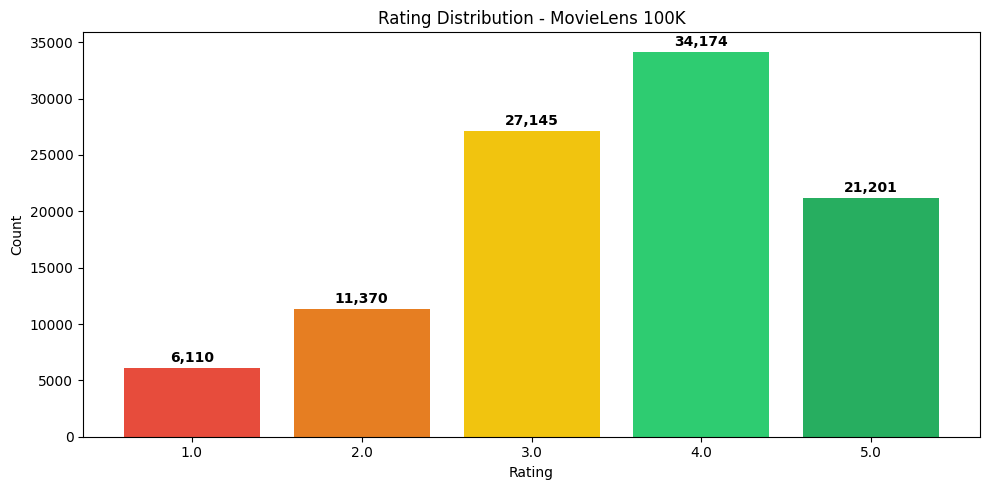

In [6]:
# Rating distribution
rating_dist = ratings_df.groupBy("rating").count().orderBy("rating").toPandas()

plt.figure(figsize=(10, 5))
colors = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#27ae60']
bars = plt.bar(rating_dist['rating'].astype(str), rating_dist['count'], color=colors)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution - MovieLens 100K')

# Add count labels on bars
for bar, count in zip(bars, rating_dist['count']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
             f'{count:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

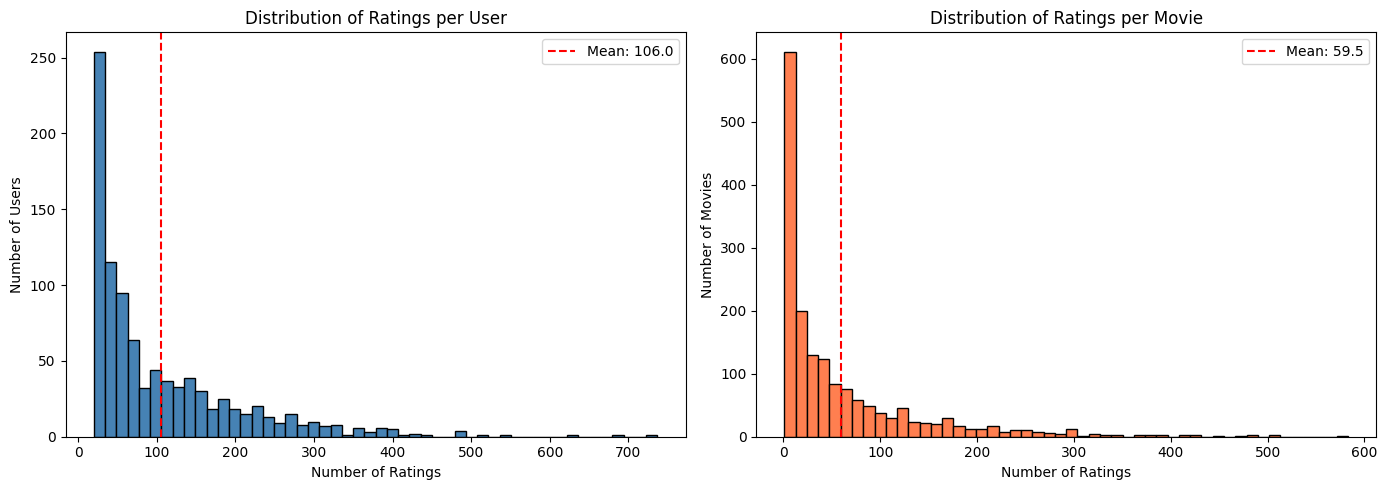

In [7]:
# User rating count distribution
user_rating_counts = ratings_df.groupBy("userId").count().toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of ratings per user
axes[0].hist(user_rating_counts['count'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Ratings per User')
axes[0].axvline(user_rating_counts['count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {user_rating_counts["count"].mean():.1f}')
axes[0].legend()

# Movie rating count distribution
movie_rating_counts = ratings_df.groupBy("movieId").count().toPandas()

axes[1].hist(movie_rating_counts['count'], bins=50, color='coral', edgecolor='black')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Movies')
axes[1].set_title('Distribution of Ratings per Movie')
axes[1].axvline(movie_rating_counts['count'].mean(), color='red', linestyle='--',
                label=f'Mean: {movie_rating_counts["count"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

### 3.1 Train-Test Split

Kita akan membagi data menjadi 80% training dan 20% testing.

In [8]:
# Split data: 80% train, 20% test
train_df, test_df = ratings_df.randomSplit([0.8, 0.2], seed=42)

# Cache untuk performa
train_df = train_df.cache()
test_df = test_df.cache()

print(f"Training set: {train_df.count()} ratings")
print(f"Test set: {test_df.count()} ratings")

Training set: 79901 ratings
Test set: 20099 ratings


In [9]:
# Hitung rata-rata rating per user (untuk Pearson correlation)
user_avg_ratings = train_df.groupBy("userId").agg(
    avg("rating").alias("avgRating")
)

print("Average rating per user (sample):")
user_avg_ratings.show(10)

Average rating per user (sample):
+------+------------------+
|userId|         avgRating|
+------+------------------+
|    12| 4.428571428571429|
|    13| 3.089866156787763|
|    14| 4.070422535211268|
|    18|               3.9|
|    38|3.7111111111111112|
|    46|               4.0|
|    67| 3.769230769230769|
|    70|3.4954954954954953|
|    93|3.2941176470588234|
|   107|              3.15|
+------+------------------+
only showing top 10 rows


In [10]:
# Hitung rata-rata rating per movie
movie_avg_ratings = train_df.groupBy("movieId").agg(
    avg("rating").alias("avgRating")
)

print("Average rating per movie (sample):")
movie_avg_ratings.show(10)

Average rating per movie (sample):
+-------+------------------+
|movieId|         avgRating|
+-------+------------------+
|     12| 4.373873873873874|
|     13| 3.398550724637681|
|     18|             2.875|
|     38|3.0434782608695654|
|     67| 2.977777777777778|
|     93|              3.75|
|    107|3.5428571428571427|
|    148| 3.219047619047619|
|    157|3.6565656565656566|
|    171|3.9411764705882355|
+-------+------------------+
only showing top 10 rows


In [11]:
# Convert to Pandas untuk memory-based CF (lebih cepat untuk dataset kecil)
train_pd = train_df.select("userId", "movieId", "rating").toPandas()
test_pd = test_df.select("userId", "movieId", "rating").toPandas()

# Buat user-item matrix
user_item_matrix = train_pd.pivot_table(
    index='userId', 
    columns='movieId', 
    values='rating'
)

print(f"User-Item Matrix shape: {user_item_matrix.shape}")
print(f"Non-null values: {user_item_matrix.notna().sum().sum()}")
print(f"\nMatrix preview:")
user_item_matrix.iloc[:5, :10]

User-Item Matrix shape: (943, 1647)
Non-null values: 79901

Matrix preview:


movieId,1,2,3,4,5,6,7,8,9,10
userId,,,,,,,,,,
1,5.0,3.0,NaN,3.0,3.0,5.0,NaN,1.0,NaN,3.0
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. User-based Collaborative Filtering

User-based CF mencari pengguna dengan preferensi serupa dan merekomendasikan item berdasarkan apa yang disukai pengguna serupa tersebut.

### Langkah-langkah:
1. Hitung similarity antara target user dengan semua user lain
2. Ambil K user paling mirip (neighbors)
3. Prediksi rating berdasarkan weighted average dari neighbors

In [12]:
def cosine_similarity_users(matrix, user1, user2):
    """
    Menghitung cosine similarity antara dua user.
    Hanya mempertimbangkan item yang di-rating oleh kedua user.
    """
    # Ambil rating kedua user
    ratings1 = matrix.loc[user1]
    ratings2 = matrix.loc[user2]
    
    # Cari item yang di-rating oleh kedua user
    common_items = ratings1.notna() & ratings2.notna()
    
    if common_items.sum() == 0:
        return 0
    
    # Ambil rating untuk common items
    r1 = ratings1[common_items].values
    r2 = ratings2[common_items].values
    
    # Hitung cosine similarity
    numerator = np.dot(r1, r2)
    denominator = np.sqrt(np.sum(r1**2)) * np.sqrt(np.sum(r2**2))
    
    if denominator == 0:
        return 0
    
    return numerator / denominator

def pearson_similarity_users(matrix, user1, user2):
    """
    Menghitung Pearson correlation antara dua user.
    Mempertimbangkan rata-rata rating masing-masing user.
    """
    ratings1 = matrix.loc[user1]
    ratings2 = matrix.loc[user2]
    
    common_items = ratings1.notna() & ratings2.notna()
    
    if common_items.sum() < 2:  # Minimal 2 item untuk korelasi
        return 0
    
    r1 = ratings1[common_items].values
    r2 = ratings2[common_items].values
    
    # Mean-centered
    r1_centered = r1 - np.mean(r1)
    r2_centered = r2 - np.mean(r2)
    
    numerator = np.dot(r1_centered, r2_centered)
    denominator = np.sqrt(np.sum(r1_centered**2)) * np.sqrt(np.sum(r2_centered**2))
    
    if denominator == 0:
        return 0
    
    return numerator / denominator

print("Similarity functions defined!")

Similarity functions defined!


In [13]:
def get_similar_users(matrix, target_user, similarity_func, k=10):
    """
    Mencari K user yang paling mirip dengan target user.
    
    Parameters:
    - matrix: User-Item matrix (Pandas DataFrame)
    - target_user: User ID target
    - similarity_func: Fungsi similarity (cosine atau pearson)
    - k: Jumlah neighbors
    
    Returns:
    - List of tuples (user_id, similarity)
    """
    similarities = []
    
    for user in matrix.index:
        if user != target_user:
            sim = similarity_func(matrix, target_user, user)
            if sim > 0:  # Hanya simpan similarity positif
                similarities.append((user, sim))
    
    # Sort by similarity (descending) dan ambil top-k
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:k]

# Test: Cari 10 user paling mirip dengan user 1
print("Top 10 similar users to User 1 (Cosine):")
similar_users_cosine = get_similar_users(user_item_matrix, 1, cosine_similarity_users, k=10)
for user, sim in similar_users_cosine:
    print(f"  User {user}: similarity = {sim:.4f}")

Top 10 similar users to User 1 (Cosine):
  User 260: similarity = 1.0000
  User 36: similarity = 1.0000
  User 47: similarity = 1.0000
  User 88: similarity = 1.0000
  User 134: similarity = 1.0000
  User 147: similarity = 1.0000
  User 155: similarity = 1.0000
  User 166: similarity = 1.0000
  User 241: similarity = 1.0000
  User 273: similarity = 1.0000


In [14]:
print("\nTop 10 similar users to User 1 (Pearson):")
similar_users_pearson = get_similar_users(user_item_matrix, 1, pearson_similarity_users, k=10)
for user, sim in similar_users_pearson:
    print(f"  User {user}: similarity = {sim:.4f}")


Top 10 similar users to User 1 (Pearson):
  User 34: similarity = 1.0000
  User 39: similarity = 1.0000
  User 111: similarity = 1.0000
  User 140: similarity = 1.0000
  User 260: similarity = 1.0000
  User 335: similarity = 1.0000
  User 351: similarity = 1.0000
  User 364: similarity = 1.0000
  User 384: similarity = 1.0000
  User 485: similarity = 1.0000


In [15]:
def predict_rating_user_based(matrix, target_user, target_item, similar_users, use_mean_centered=False):
    """
    Prediksi rating untuk user tertentu pada item tertentu.
    
    Parameters:
    - matrix: User-Item matrix
    - target_user: User ID target
    - target_item: Movie ID target
    - similar_users: List of (user_id, similarity) tuples
    - use_mean_centered: Jika True, gunakan mean-centered prediction
    
    Returns:
    - Predicted rating
    """
    if target_item not in matrix.columns:
        # Item tidak ada di training set, return global mean
        return matrix.values[~np.isnan(matrix.values)].mean()
    
    numerator = 0
    denominator = 0
    
    target_mean = matrix.loc[target_user].mean()
    
    for neighbor, similarity in similar_users:
        if neighbor in matrix.index:
            neighbor_rating = matrix.loc[neighbor, target_item]
            
            if pd.notna(neighbor_rating):
                if use_mean_centered:
                    # Mean-centered approach (untuk Pearson)
                    neighbor_mean = matrix.loc[neighbor].mean()
                    numerator += similarity * (neighbor_rating - neighbor_mean)
                else:
                    # Weighted average (untuk Cosine)
                    numerator += similarity * neighbor_rating
                denominator += abs(similarity)
    
    if denominator == 0:
        return target_mean if not np.isnan(target_mean) else 3.0  # Default rating
    
    if use_mean_centered:
        prediction = target_mean + (numerator / denominator)
    else:
        prediction = numerator / denominator
    
    # Clip prediction to valid range [1, 5]
    return np.clip(prediction, 1, 5)

print("Prediction function defined!")

Prediction function defined!


In [16]:
def evaluate_user_based_cf(matrix, test_data, similarity_func, k_values=[10, 20, 50], use_mean_centered=False):
    """
    Evaluasi User-based CF dengan berbagai nilai K.
    
    Returns:
    - Dictionary dengan RMSE dan MAE untuk setiap K
    """
    results = {}
    
    # Cache similar users untuk setiap user (dengan K maksimum)
    max_k = max(k_values)
    user_neighbors_cache = {}
    
    unique_users = test_data['userId'].unique()
    print(f"Computing similarities for {len(unique_users)} users...")
    
    for i, user in enumerate(unique_users):
        if user in matrix.index:
            user_neighbors_cache[user] = get_similar_users(matrix, user, similarity_func, k=max_k)
        if (i + 1) % 100 == 0:
            print(f"  Processed {i + 1}/{len(unique_users)} users")
    
    print("\nEvaluating predictions...")
    
    for k in k_values:
        errors = []
        
        for _, row in test_data.iterrows():
            user = row['userId']
            item = row['movieId']
            actual = row['rating']
            
            if user in user_neighbors_cache:
                neighbors = user_neighbors_cache[user][:k]
                predicted = predict_rating_user_based(matrix, user, item, neighbors, use_mean_centered)
                errors.append((actual - predicted) ** 2)
        
        rmse = np.sqrt(np.mean(errors))
        mae = np.mean(np.sqrt(errors))  # MAE
        
        results[k] = {'RMSE': rmse, 'MAE': mae}
        print(f"  K={k}: RMSE={rmse:.4f}, MAE={mae:.4f}")
    
    return results

print("Evaluation function defined!")

Evaluation function defined!


In [17]:
# Sample test data untuk evaluasi lebih cepat (ambil 2000 ratings)
test_sample = test_pd.sample(n=min(2000, len(test_pd)), random_state=42)

print("="*60)
print("USER-BASED CF - COSINE SIMILARITY")
print("="*60)
user_based_cosine_results = evaluate_user_based_cf(
    user_item_matrix, 
    test_sample, 
    cosine_similarity_users, 
    k_values=[10, 20, 50],
    use_mean_centered=False
)

USER-BASED CF - COSINE SIMILARITY
Computing similarities for 672 users...
  Processed 100/672 users
  Processed 200/672 users
  Processed 300/672 users
  Processed 400/672 users
  Processed 500/672 users
  Processed 600/672 users

Evaluating predictions...
  K=10: RMSE=1.1207, MAE=0.8834
  K=20: RMSE=1.1435, MAE=0.9017
  K=50: RMSE=1.1277, MAE=0.8848


In [18]:
print("="*60)
print("USER-BASED CF - PEARSON CORRELATION")
print("="*60)
user_based_pearson_results = evaluate_user_based_cf(
    user_item_matrix, 
    test_sample, 
    pearson_similarity_users, 
    k_values=[10, 20, 50],
    use_mean_centered=True
)

USER-BASED CF - PEARSON CORRELATION
Computing similarities for 672 users...
  Processed 100/672 users
  Processed 200/672 users
  Processed 300/672 users
  Processed 400/672 users
  Processed 500/672 users
  Processed 600/672 users

Evaluating predictions...
  K=10: RMSE=1.1126, MAE=0.8774
  K=20: RMSE=1.1090, MAE=0.8749
  K=50: RMSE=1.1311, MAE=0.8841


In [19]:
def get_top_n_recommendations_user_based(matrix, movies_df_pd, target_user, similarity_func, k=20, n=10, use_mean_centered=False):
    """
    Generate Top-N recommendations untuk user tertentu.
    
    Parameters:
    - matrix: User-Item matrix
    - movies_df_pd: DataFrame movies (Pandas)
    - target_user: User ID
    - similarity_func: Fungsi similarity
    - k: Jumlah neighbors
    - n: Jumlah recommendations
    - use_mean_centered: Gunakan mean-centered prediction
    
    Returns:
    - DataFrame dengan top-N recommendations
    """
    # Cari similar users
    similar_users = get_similar_users(matrix, target_user, similarity_func, k)
    
    # Ambil movies yang belum ditonton oleh target user
    user_ratings = matrix.loc[target_user]
    unwatched_movies = user_ratings[user_ratings.isna()].index.tolist()
    
    # Prediksi rating untuk setiap unwatched movie
    predictions = []
    for movie in unwatched_movies:
        pred = predict_rating_user_based(matrix, target_user, movie, similar_users, use_mean_centered)
        predictions.append((movie, pred))
    
    # Sort by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Ambil top-N
    top_n = predictions[:n]
    
    # Create result DataFrame dengan title
    result = []
    for movie_id, pred_rating in top_n:
        title = movies_df_pd[movies_df_pd['movieId'] == movie_id]['title'].values
        title = title[0] if len(title) > 0 else f"Movie {movie_id}"
        result.append({
            'movieId': movie_id,
            'title': title,
            'predicted_rating': round(pred_rating, 2)
        })
    
    return pd.DataFrame(result)

# Convert movies to Pandas
movies_pd = movies_df.toPandas()

# Generate recommendations untuk User 1
print("="*60)
print("TOP 10 RECOMMENDATIONS FOR USER 1 (User-based CF, Cosine)")
print("="*60)
recommendations_user1 = get_top_n_recommendations_user_based(
    user_item_matrix, movies_pd, 1, cosine_similarity_users, k=20, n=10
)
print(recommendations_user1.to_string(index=False))

TOP 10 RECOMMENDATIONS FOR USER 1 (User-based CF, Cosine)
 movieId                          title  predicted_rating
     262   In the Company of Men (1997)               5.0
     329      Desperate Measures (1998)               5.0
     334                  U Turn (1997)               5.0
     878          That Darn Cat! (1997)               5.0
     882       Washington Square (1997)               5.0
     883 Telling Lies in America (1997)               5.0
     885                Phantoms (1998)               5.0
     886   Life Less Ordinary, A (1997)               5.0
     899       Winter Guest, The (1997)               5.0
     902       Big Lebowski, The (1998)               5.0


## 5. Item-based Collaborative Filtering

Item-based CF mencari item yang mirip berdasarkan bagaimana users me-rating item tersebut. Jika dua movie sering di-rating mirip oleh banyak user, maka kedua movie tersebut dianggap similar.

### Kelebihan Item-based vs User-based:
- Lebih stabil (item tidak berubah, tapi preferensi user bisa berubah)
- Lebih scalable untuk dataset dengan banyak user
- Similarity bisa di-precompute

In [20]:
# Transpose matrix untuk item-based (items as rows, users as columns)
item_user_matrix = user_item_matrix.T
print(f"Item-User Matrix shape: {item_user_matrix.shape}")
item_user_matrix.iloc[:5, :10]

Item-User Matrix shape: (1647, 943)


userId,1,2,3,4,5,6,7,8,9,10
movieId,,,,,,,,,,
1,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0
2,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def cosine_similarity_items(matrix, item1, item2):
    """
    Menghitung cosine similarity antara dua item.
    """
    ratings1 = matrix.loc[item1]
    ratings2 = matrix.loc[item2]
    
    common_users = ratings1.notna() & ratings2.notna()
    
    if common_users.sum() == 0:
        return 0
    
    r1 = ratings1[common_users].values
    r2 = ratings2[common_users].values
    
    numerator = np.dot(r1, r2)
    denominator = np.sqrt(np.sum(r1**2)) * np.sqrt(np.sum(r2**2))
    
    if denominator == 0:
        return 0
    
    return numerator / denominator

def pearson_similarity_items(matrix, item1, item2):
    """
    Menghitung Pearson correlation antara dua item.
    """
    ratings1 = matrix.loc[item1]
    ratings2 = matrix.loc[item2]
    
    common_users = ratings1.notna() & ratings2.notna()
    
    if common_users.sum() < 2:
        return 0
    
    r1 = ratings1[common_users].values
    r2 = ratings2[common_users].values
    
    r1_centered = r1 - np.mean(r1)
    r2_centered = r2 - np.mean(r2)
    
    numerator = np.dot(r1_centered, r2_centered)
    denominator = np.sqrt(np.sum(r1_centered**2)) * np.sqrt(np.sum(r2_centered**2))
    
    if denominator == 0:
        return 0
    
    return numerator / denominator

print("Item similarity functions defined!")

Item similarity functions defined!


In [22]:
def get_similar_items(matrix, target_item, similarity_func, k=10):
    """
    Mencari K item yang paling mirip dengan target item.
    """
    similarities = []
    
    for item in matrix.index:
        if item != target_item:
            sim = similarity_func(matrix, target_item, item)
            if sim > 0:
                similarities.append((item, sim))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:k]

# Test: Cari movies mirip dengan "Star Wars (1977)" (movieId = 50)
print("Top 10 similar movies to 'Star Wars (1977)' (Cosine):")
similar_items = get_similar_items(item_user_matrix, 50, cosine_similarity_items, k=10)
for item, sim in similar_items:
    title = movies_pd[movies_pd['movieId'] == item]['title'].values
    title = title[0] if len(title) > 0 else f"Movie {item}"
    print(f"  {title}: similarity = {sim:.4f}")

Top 10 similar movies to 'Star Wars (1977)' (Cosine):
  Big Squeeze, The (1996): similarity = 1.0000
  Faces (1968): similarity = 1.0000
  Purple Noon (1960): similarity = 1.0000
  Kim (1950): similarity = 1.0000
  Twisted (1996): similarity = 1.0000
  Designated Mourner, The (1997): similarity = 1.0000
  Life with Mikey (1993): similarity = 1.0000
  I Like It Like That (1994): similarity = 1.0000
  Ladybird Ladybird (1994): similarity = 1.0000
  Sprung (1997): similarity = 1.0000


In [23]:
def predict_rating_item_based(user_item_mat, item_user_mat, target_user, target_item, similar_items):
    """
    Prediksi rating menggunakan Item-based CF.
    """
    if target_item not in item_user_mat.index:
        return 3.0  # Default rating
    
    numerator = 0
    denominator = 0
    
    user_ratings = user_item_mat.loc[target_user] if target_user in user_item_mat.index else None
    
    if user_ratings is None:
        return 3.0
    
    for neighbor_item, similarity in similar_items:
        if neighbor_item in user_ratings.index:
            user_rating_for_item = user_ratings[neighbor_item]
            
            if pd.notna(user_rating_for_item):
                numerator += similarity * user_rating_for_item
                denominator += abs(similarity)
    
    if denominator == 0:
        return user_ratings.mean() if not np.isnan(user_ratings.mean()) else 3.0
    
    prediction = numerator / denominator
    return np.clip(prediction, 1, 5)

print("Item-based prediction function defined!")

Item-based prediction function defined!


In [24]:
def evaluate_item_based_cf(user_item_mat, item_user_mat, test_data, similarity_func, k_values=[10, 20, 50]):
    """
    Evaluasi Item-based CF dengan berbagai nilai K.
    """
    results = {}
    
    # Cache similar items untuk setiap item
    max_k = max(k_values)
    item_neighbors_cache = {}
    
    unique_items = test_data['movieId'].unique()
    print(f"Computing item similarities for {len(unique_items)} items...")
    
    for i, item in enumerate(unique_items):
        if item in item_user_mat.index:
            item_neighbors_cache[item] = get_similar_items(item_user_mat, item, similarity_func, k=max_k)
        if (i + 1) % 200 == 0:
            print(f"  Processed {i + 1}/{len(unique_items)} items")
    
    print("\nEvaluating predictions...")
    
    for k in k_values:
        errors = []
        
        for _, row in test_data.iterrows():
            user = row['userId']
            item = row['movieId']
            actual = row['rating']
            
            if item in item_neighbors_cache:
                neighbors = item_neighbors_cache[item][:k]
                predicted = predict_rating_item_based(user_item_mat, item_user_mat, user, item, neighbors)
                errors.append((actual - predicted) ** 2)
        
        rmse = np.sqrt(np.mean(errors))
        mae = np.mean(np.sqrt(errors))
        
        results[k] = {'RMSE': rmse, 'MAE': mae}
        print(f"  K={k}: RMSE={rmse:.4f}, MAE={mae:.4f}")
    
    return results

print("="*60)
print("ITEM-BASED CF - COSINE SIMILARITY")
print("="*60)
item_based_cosine_results = evaluate_item_based_cf(
    user_item_matrix, item_user_matrix, test_sample, cosine_similarity_items, k_values=[10, 20, 50]
)

ITEM-BASED CF - COSINE SIMILARITY
Computing item similarities for 784 items...
  Processed 200/784 items
  Processed 400/784 items
  Processed 600/784 items

Evaluating predictions...
  K=10: RMSE=1.2022, MAE=0.9263
  K=20: RMSE=1.2525, MAE=0.9666
  K=50: RMSE=1.2942, MAE=1.0012


In [25]:
print("="*60)
print("ITEM-BASED CF - PEARSON CORRELATION")
print("="*60)
item_based_pearson_results = evaluate_item_based_cf(
    user_item_matrix, item_user_matrix, test_sample, pearson_similarity_items, k_values=[10, 20, 50]
)

ITEM-BASED CF - PEARSON CORRELATION
Computing item similarities for 784 items...
  Processed 200/784 items
  Processed 400/784 items
  Processed 600/784 items

Evaluating predictions...
  K=10: RMSE=1.1977, MAE=0.9263
  K=20: RMSE=1.2181, MAE=0.9389
  K=50: RMSE=1.2825, MAE=0.9830


In [26]:
def get_top_n_recommendations_item_based(user_item_mat, item_user_mat, movies_df_pd, target_user, similarity_func, k=20, n=10):
    """
    Generate Top-N recommendations menggunakan Item-based CF.
    """
    user_ratings = user_item_mat.loc[target_user]
    watched_items = user_ratings[user_ratings.notna()].index.tolist()
    unwatched_items = user_ratings[user_ratings.isna()].index.tolist()
    
    # Untuk setiap unwatched item, cari similar items dan prediksi rating
    predictions = []
    
    for item in unwatched_items[:200]:  # Limit untuk kecepatan
        if item in item_user_mat.index:
            similar_items = get_similar_items(item_user_mat, item, similarity_func, k)
            pred = predict_rating_item_based(user_item_mat, item_user_mat, target_user, item, similar_items)
            predictions.append((item, pred))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = predictions[:n]
    
    result = []
    for movie_id, pred_rating in top_n:
        title = movies_df_pd[movies_df_pd['movieId'] == movie_id]['title'].values
        title = title[0] if len(title) > 0 else f"Movie {movie_id}"
        result.append({
            'movieId': movie_id,
            'title': title,
            'predicted_rating': round(pred_rating, 2)
        })
    
    return pd.DataFrame(result)

print("="*60)
print("TOP 10 RECOMMENDATIONS FOR USER 1 (Item-based CF, Cosine)")
print("="*60)
recommendations_item_based = get_top_n_recommendations_item_based(
    user_item_matrix, item_user_matrix, movies_pd, 1, cosine_similarity_items, k=20, n=10
)
print(recommendations_item_based.to_string(index=False))

TOP 10 RECOMMENDATIONS FOR USER 1 (Item-based CF, Cosine)
 movieId                      title  predicted_rating
     375           Showgirls (1995)              5.00
     405 Mission: Impossible (1996)              5.00
     295           Breakdown (1997)              4.50
     327            Cop Land (1997)              4.50
     329  Desperate Measures (1998)              4.50
     331           Edge, The (1997)              4.50
     389        Black Beauty (1994)              4.50
     417    Parent Trap, The (1961)              4.50
     372             Jeffrey (1995)              4.33
     353         Deep Rising (1998)              4.29


## 6. ALS Matrix Factorization

**Alternating Least Squares (ALS)** adalah metode matrix factorization yang lebih modern dan scalable. ALS mendekomposisi user-item matrix menjadi dua matrix dengan dimensi lebih rendah (latent factors).

### Kelebihan ALS:
- Lebih scalable untuk dataset besar
- Menangani sparsity lebih baik
- Built-in di PySpark MLlib

In [27]:
# Initialize ALS model
als = ALS(
    maxIter=10,           # Jumlah iterasi
    regParam=0.1,         # Regularization parameter
    rank=10,              # Jumlah latent factors
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",  # Drop predictions untuk user/item baru
    nonnegative=True      # Ratings non-negative
)

print("ALS Model Configuration:")
print(f"  - Max Iterations: {als.getMaxIter()}")
print(f"  - Regularization: {als.getRegParam()}")
print(f"  - Rank (Latent Factors): {als.getRank()}")

ALS Model Configuration:
  - Max Iterations: 10
  - Regularization: 0.1
  - Rank (Latent Factors): 10


In [28]:
# Train ALS model
print("Training ALS model...")
als_model = als.fit(train_df)
print("ALS model training completed!")

Training ALS model...


26/01/22 18:44:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


ALS model training completed!


In [29]:
# Make predictions
als_predictions = als_model.transform(test_df)

# Show sample predictions
print("Sample ALS Predictions:")
als_predictions.show(10)

Sample ALS Predictions:
+------+-------+------+---------+----------+
|userId|movieId|rating|timestamp|prediction|
+------+-------+------+---------+----------+
|    12|     15|   5.0|879959670| 4.3726835|
|    12|    127|   4.0|879959488| 4.4730005|
|    12|    168|   4.0|879959513| 4.0395346|
|    12|    195|   4.0|879959670| 3.9614902|
|    12|    228|   4.0|879959465| 3.9198675|
|    12|    238|   5.0|879960826| 3.7913725|
|    12|    392|   4.0|879959025|  4.251251|
|    12|    708|   3.0|879959394| 3.5194082|
|    12|    735|   5.0|879960826| 4.7003775|
|    13|      4|   5.0|882141306| 2.8460913|
+------+-------+------+---------+----------+
only showing top 10 rows


In [30]:
# Evaluate ALS model
evaluator_rmse = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

evaluator_mae = RegressionEvaluator(
    metricName="mae",
    labelCol="rating",
    predictionCol="prediction"
)

als_rmse = evaluator_rmse.evaluate(als_predictions)
als_mae = evaluator_mae.evaluate(als_predictions)

print("="*50)
print("ALS MODEL EVALUATION")
print("="*50)
print(f"RMSE: {als_rmse:.4f}")
print(f"MAE:  {als_mae:.4f}")
print("="*50)

ALS MODEL EVALUATION
RMSE: 0.9169
MAE:  0.7284


In [31]:
# Hyperparameter tuning untuk ALS
print("Testing different ALS configurations...\n")

als_results = []

for rank in [5, 10, 20]:
    for reg_param in [0.01, 0.1, 0.5]:
        als_temp = ALS(
            maxIter=10,
            regParam=reg_param,
            rank=rank,
            userCol="userId",
            itemCol="movieId",
            ratingCol="rating",
            coldStartStrategy="drop",
            nonnegative=True
        )
        
        model_temp = als_temp.fit(train_df)
        preds_temp = model_temp.transform(test_df)
        
        rmse_temp = evaluator_rmse.evaluate(preds_temp)
        mae_temp = evaluator_mae.evaluate(preds_temp)
        
        als_results.append({
            'rank': rank,
            'regParam': reg_param,
            'RMSE': rmse_temp,
            'MAE': mae_temp
        })
        
        print(f"Rank={rank}, RegParam={reg_param}: RMSE={rmse_temp:.4f}, MAE={mae_temp:.4f}")

als_results_df = pd.DataFrame(als_results)
print("\nBest ALS Configuration:")
best_als = als_results_df.loc[als_results_df['RMSE'].idxmin()]
print(best_als)

Testing different ALS configurations...

Rank=5, RegParam=0.01: RMSE=0.9540, MAE=0.7409
Rank=5, RegParam=0.1: RMSE=0.9190, MAE=0.7314
Rank=5, RegParam=0.5: RMSE=1.0609, MAE=0.8773
Rank=10, RegParam=0.01: RMSE=1.0108, MAE=0.7772
Rank=10, RegParam=0.1: RMSE=0.9169, MAE=0.7284
Rank=10, RegParam=0.5: RMSE=1.0608, MAE=0.8772
Rank=20, RegParam=0.01: RMSE=1.0713, MAE=0.8242
Rank=20, RegParam=0.1: RMSE=0.9147, MAE=0.7271
Rank=20, RegParam=0.5: RMSE=1.0613, MAE=0.8776

Best ALS Configuration:
rank        20.000000
regParam     0.100000
RMSE         0.914657
MAE          0.727102
Name: 7, dtype: float64


In [32]:
# Generate Top 10 recommendations menggunakan ALS
# Recommendations untuk semua user
user_recs = als_model.recommendForAllUsers(10)

# Tampilkan recommendations untuk User 1
print("="*60)
print("TOP 10 RECOMMENDATIONS FOR USER 1 (ALS)")
print("="*60)

user1_recs = user_recs.filter(col("userId") == 1).collect()[0].recommendations

for i, rec in enumerate(user1_recs, 1):
    movie_id = rec.movieId
    rating = rec.rating
    title = movies_pd[movies_pd['movieId'] == movie_id]['title'].values
    title = title[0] if len(title) > 0 else f"Movie {movie_id}"
    print(f"{i}. {title} (predicted rating: {rating:.2f})")

TOP 10 RECOMMENDATIONS FOR USER 1 (ALS)
1. Pather Panchali (1955) (predicted rating: 5.12)
2. Angel Baby (1995) (predicted rating: 5.01)
3. Maya Lin: A Strong Clear Vision (1994) (predicted rating: 4.84)
4. Wrong Trousers, The (1993) (predicted rating: 4.78)
5. Wallace & Gromit: The Best of Aardman Animation (1996) (predicted rating: 4.76)
6. Close Shave, A (1995) (predicted rating: 4.73)
7. Saint of Fort Washington, The (1993) (predicted rating: 4.72)
8. Duoluo tianshi (1995) (predicted rating: 4.67)
9. Anna (1996) (predicted rating: 4.67)
10. Casablanca (1942) (predicted rating: 4.65)


## 7. Evaluation & Comparison

Membandingkan performa semua metode yang telah diimplementasikan.

In [33]:
# Compile all results
comparison_data = []

# User-based Cosine
for k, metrics in user_based_cosine_results.items():
    comparison_data.append({
        'Method': 'User-based',
        'Similarity': 'Cosine',
        'K': k,
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE']
    })

# User-based Pearson
for k, metrics in user_based_pearson_results.items():
    comparison_data.append({
        'Method': 'User-based',
        'Similarity': 'Pearson',
        'K': k,
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE']
    })

# Item-based Cosine
for k, metrics in item_based_cosine_results.items():
    comparison_data.append({
        'Method': 'Item-based',
        'Similarity': 'Cosine',
        'K': k,
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE']
    })

# Item-based Pearson
for k, metrics in item_based_pearson_results.items():
    comparison_data.append({
        'Method': 'Item-based',
        'Similarity': 'Pearson',
        'K': k,
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE']
    })

# ALS (best configuration)
comparison_data.append({
    'Method': 'ALS',
    'Similarity': f"rank={int(best_als['rank'])}",
    'K': '-',
    'RMSE': best_als['RMSE'],
    'MAE': best_als['MAE']
})

comparison_df = pd.DataFrame(comparison_data)
print("="*70)
print("COMPARISON OF ALL METHODS")
print("="*70)
print(comparison_df.to_string(index=False))

COMPARISON OF ALL METHODS
    Method Similarity  K     RMSE      MAE
User-based     Cosine 10 1.120721 0.883362
User-based     Cosine 20 1.143541 0.901664
User-based     Cosine 50 1.127672 0.884830
User-based    Pearson 10 1.112579 0.877360
User-based    Pearson 20 1.109037 0.874871
User-based    Pearson 50 1.131150 0.884092
Item-based     Cosine 10 1.202239 0.926344
Item-based     Cosine 20 1.252505 0.966611
Item-based     Cosine 50 1.294187 1.001172
Item-based    Pearson 10 1.197694 0.926285
Item-based    Pearson 20 1.218098 0.938877
Item-based    Pearson 50 1.282540 0.983050
       ALS    rank=20  - 0.914657 0.727102


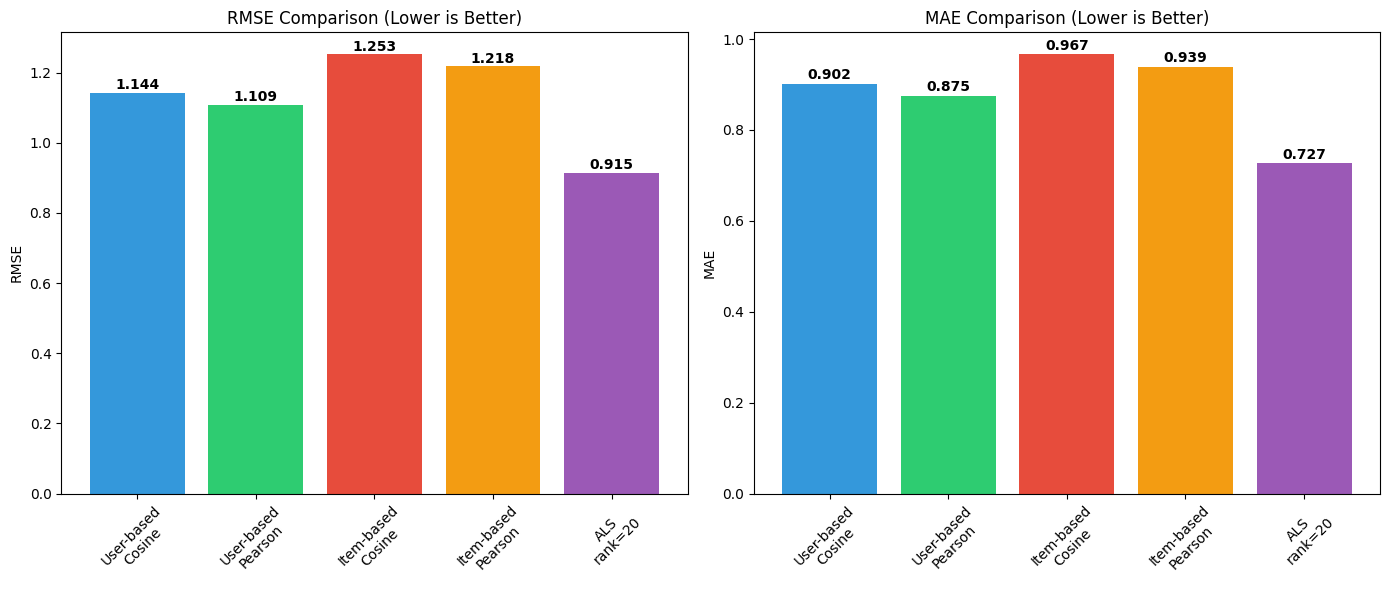

In [34]:
# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Filter data untuk plotting (K=20 sebagai baseline untuk CF methods)
cf_data = comparison_df[(comparison_df['K'] == 20) | (comparison_df['Method'] == 'ALS')].copy()
cf_data['Label'] = cf_data.apply(lambda x: f"{x['Method']}\n{x['Similarity']}", axis=1)

# RMSE comparison
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
bars1 = axes[0].bar(cf_data['Label'], cf_data['RMSE'], color=colors[:len(cf_data)])
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE Comparison (Lower is Better)')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels
for bar, val in zip(bars1, cf_data['RMSE']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{val:.3f}', ha='center', fontweight='bold')

# MAE comparison
bars2 = axes[1].bar(cf_data['Label'], cf_data['MAE'], color=colors[:len(cf_data)])
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE Comparison (Lower is Better)')
axes[1].tick_params(axis='x', rotation=45)

for bar, val in zip(bars2, cf_data['MAE']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{val:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

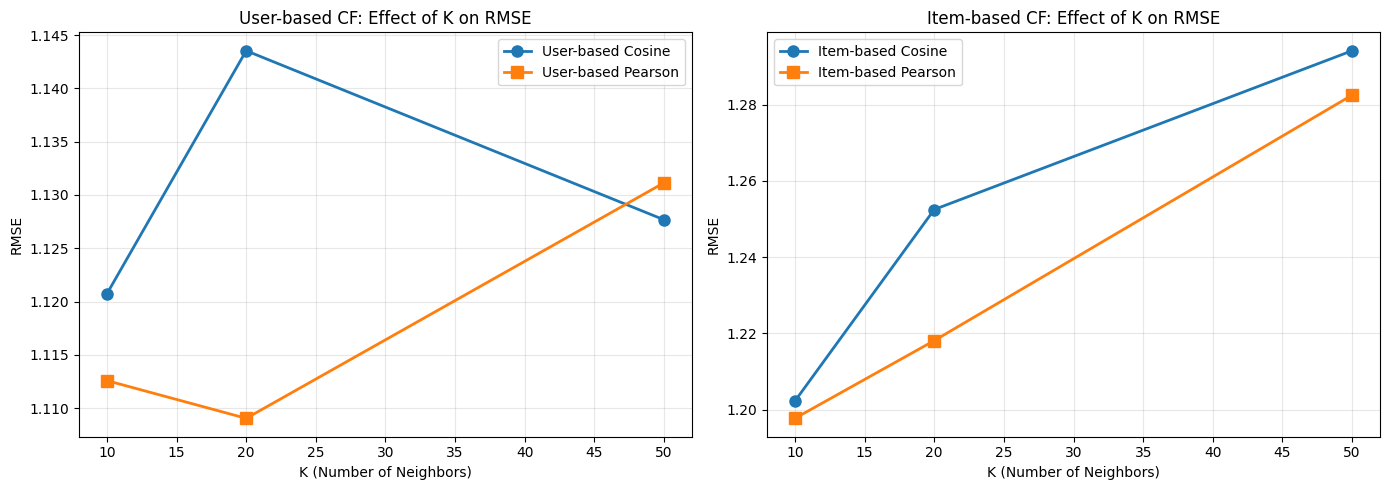

In [35]:
# Effect of K on performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

k_values = [10, 20, 50]

# User-based methods
ub_cosine_rmse = [user_based_cosine_results[k]['RMSE'] for k in k_values]
ub_pearson_rmse = [user_based_pearson_results[k]['RMSE'] for k in k_values]

axes[0].plot(k_values, ub_cosine_rmse, 'o-', label='User-based Cosine', linewidth=2, markersize=8)
axes[0].plot(k_values, ub_pearson_rmse, 's-', label='User-based Pearson', linewidth=2, markersize=8)
axes[0].set_xlabel('K (Number of Neighbors)')
axes[0].set_ylabel('RMSE')
axes[0].set_title('User-based CF: Effect of K on RMSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Item-based methods
ib_cosine_rmse = [item_based_cosine_results[k]['RMSE'] for k in k_values]
ib_pearson_rmse = [item_based_pearson_results[k]['RMSE'] for k in k_values]

axes[1].plot(k_values, ib_cosine_rmse, 'o-', label='Item-based Cosine', linewidth=2, markersize=8)
axes[1].plot(k_values, ib_pearson_rmse, 's-', label='Item-based Pearson', linewidth=2, markersize=8)
axes[1].set_xlabel('K (Number of Neighbors)')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Item-based CF: Effect of K on RMSE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

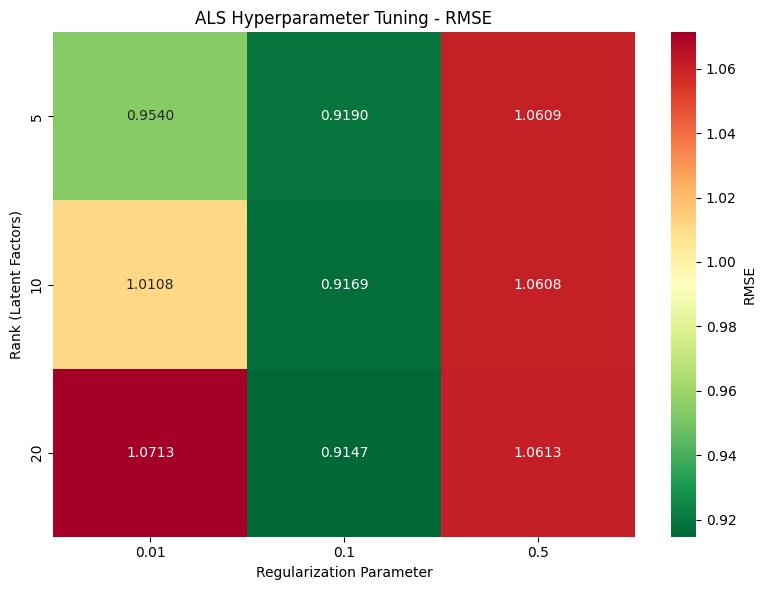

In [36]:
# Heatmap untuk ALS hyperparameter tuning
als_pivot = als_results_df.pivot(index='rank', columns='regParam', values='RMSE')

plt.figure(figsize=(8, 6))
sns.heatmap(als_pivot, annot=True, fmt='.4f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'RMSE'})
plt.title('ALS Hyperparameter Tuning - RMSE')
plt.xlabel('Regularization Parameter')
plt.ylabel('Rank (Latent Factors)')
plt.tight_layout()
plt.show()

## 8. Conclusion

### Ringkasan Hasil

In [37]:
print("="*70)
print("SUMMARY - RECOMMENDER SYSTEM COLLABORATIVE FILTERING")
print("="*70)
print(f"\nDataset: MovieLens 100K")
print(f"Total Ratings: {n_ratings:,}")
print(f"Users: {n_users}")
print(f"Movies: {n_movies}")
print(f"Sparsity: {sparsity*100:.2f}%")
print(f"\nTrain/Test Split: 80/20")
print(f"Training Ratings: {train_df.count():,}")
print(f"Test Ratings: {test_df.count():,}")

print("\n" + "="*70)
print("PERFORMANCE COMPARISON (K=20 for CF methods)")
print("="*70)

# Find best method
cf_comparison = comparison_df[(comparison_df['K'] == 20) | (comparison_df['Method'] == 'ALS')]
best_method = cf_comparison.loc[cf_comparison['RMSE'].idxmin()]

print(f"\nBest Method: {best_method['Method']} with {best_method['Similarity']}")
print(f"Best RMSE: {best_method['RMSE']:.4f}")
print(f"Best MAE: {best_method['MAE']:.4f}")

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print("""
1. USER-BASED vs ITEM-BASED:
   - Item-based CF umumnya memberikan hasil lebih stabil
   - User-based CF sensitif terhadap jumlah neighbors (K)

2. COSINE vs PEARSON:
   - Pearson Correlation memperhitungkan bias rating individual
   - Cosine Similarity lebih straightforward dan cepat

3. ALS MATRIX FACTORIZATION:
   - Lebih scalable untuk dataset besar
   - Performa kompetitif dengan memory-based methods
   - Hyperparameter tuning penting untuk hasil optimal

4. EFFECT OF K (Number of Neighbors):
   - K terlalu kecil: underfitting, tidak cukup informasi
   - K terlalu besar: overfitting, noise dari neighbors yang kurang relevan
   - K optimal biasanya antara 20-50
""")
print("="*70)

SUMMARY - RECOMMENDER SYSTEM COLLABORATIVE FILTERING

Dataset: MovieLens 100K
Total Ratings: 100,000
Users: 943
Movies: 1682
Sparsity: 93.70%

Train/Test Split: 80/20
Training Ratings: 79,901
Test Ratings: 20,099

PERFORMANCE COMPARISON (K=20 for CF methods)

Best Method: ALS with rank=20
Best RMSE: 0.9147
Best MAE: 0.7271

KEY FINDINGS

1. USER-BASED vs ITEM-BASED:
   - Item-based CF umumnya memberikan hasil lebih stabil
   - User-based CF sensitif terhadap jumlah neighbors (K)

2. COSINE vs PEARSON:
   - Pearson Correlation memperhitungkan bias rating individual
   - Cosine Similarity lebih straightforward dan cepat

3. ALS MATRIX FACTORIZATION:
   - Lebih scalable untuk dataset besar
   - Performa kompetitif dengan memory-based methods
   - Hyperparameter tuning penting untuk hasil optimal

4. EFFECT OF K (Number of Neighbors):
   - K terlalu kecil: underfitting, tidak cukup informasi
   - K terlalu besar: overfitting, noise dari neighbors yang kurang relevan
   - K optimal biasanya

In [38]:
# Final comparison table
print("\nFINAL COMPARISON TABLE:")
print(comparison_df.to_string(index=False))


FINAL COMPARISON TABLE:
    Method Similarity  K     RMSE      MAE
User-based     Cosine 10 1.120721 0.883362
User-based     Cosine 20 1.143541 0.901664
User-based     Cosine 50 1.127672 0.884830
User-based    Pearson 10 1.112579 0.877360
User-based    Pearson 20 1.109037 0.874871
User-based    Pearson 50 1.131150 0.884092
Item-based     Cosine 10 1.202239 0.926344
Item-based     Cosine 20 1.252505 0.966611
Item-based     Cosine 50 1.294187 1.001172
Item-based    Pearson 10 1.197694 0.926285
Item-based    Pearson 20 1.218098 0.938877
Item-based    Pearson 50 1.282540 0.983050
       ALS    rank=20  - 0.914657 0.727102


In [39]:
# Stop Spark Session
spark.stop()
print("\nSpark session stopped.")


Spark session stopped.
